In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/sesiones/Sesión 4-Drive_v1

/content/drive/My Drive/sesiones/Sesión 4-Drive_v1


In [3]:
ls

 data_description.gdoc                                test.csv
 data_description.txt                                 train.csv
'Stacked Regressions _ Top 4% on LeaderBoard.ipynb'


# Presentacion del dataset Housing Price California

Vamos a revisar el archivo "data_description.txt" el cual contiene un diccionario sobre el significado de las variables predictoras

In [0]:
#importamos las librerias
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import missingno as ms

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.shape

(1460, 81)

In [7]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
print("El tamaño de train antes de eliminar la columna Id es : {} ".format(train.shape))
print("El tamaño de test antes de eliminar la columna Id es : {} ".format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("El tamaño de test data despues de eliminar la columna Id es: : {} ".format(test.shape))

El tamaño de train antes de eliminar la columna Id es : (1460, 81) 
El tamaño de test antes de eliminar la columna Id es : (1459, 80) 
El tamaño de test data despues de eliminar la columna Id es: : (1459, 79) 


# Procesamiento de Datos

Los términos utilizados para este ejemplo se encuentran descritos en el siguiente enlace:
http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

##OUTLIERS

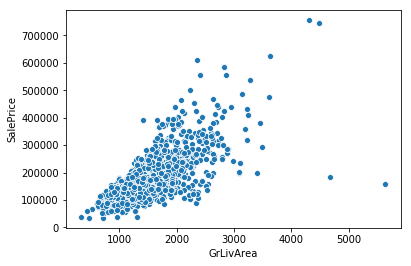

In [10]:
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

Se puede apreciar en la esquina inferior derecha dos datos que indican un **AreaHabitable** muy grande, y sin embargo registran un bajo precio. Estos valores se consideran outliers. Por ello procederemos a eliminarlos.

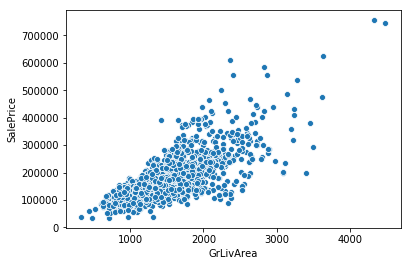

In [11]:
#Eliminamos los outliers acorde a las variables del gráfico
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Verificamos el gráfico nuevamente para confirmar que los outliers hayan sido eliminados
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

Hay probabilidades de que otros valores atipicos existan en los datos de entrenamiento (si es que alli hubieran tambien outliers), sin embargo removerlos todos puede afectar negativamente nuestros modelos. Por ello vamos a permitir aquellos en los cuales los modelos son lo suficientemente robustos.

##Variable Objetivo

**Precio** es la variable que vamos a predecir. Asi que vamos a hacer un poco de analisis en esta variable primero.


 mu = 180932.92 and sigma = 79467.79



Text(0.5, 1.0, 'SalePrice distribution')

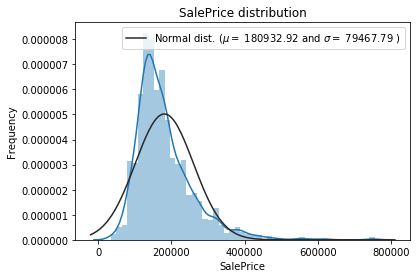

In [12]:
sns.distplot(train['SalePrice'] , fit=norm)

#Obtenemos los parámetros una vez aplicada la distribución normal a la variable Precio
#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Dibujamos ambas distribuciones la actual distribución Precio y la aproximación normal para notar la diferencia
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Se puede apreciar que los datos de la variable objetivo están sesgados (en este caso, inclinado a la izquierda). Sin embargo, los modelos lineales que veremos en la presente clase optimizan su predición con datos distribuidos normalmente. Por ello vamos a transformar los datos de esta variable para aproximarlos a una distribución normal.

 **Log-transformación de la variable objetivo**


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'SalePrice distribution')

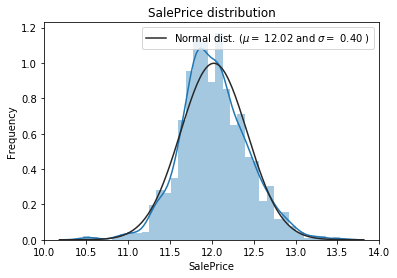

In [13]:
#Utilizamos la función log1p de la librería numpy que aplica la función log(1+x) a todos los elementos de la variable Precio
train["SalePrice"] = np.log1p(train["SalePrice"])

#Dibujamos la distribución actualizada de la variable Precio
sns.distplot(train['SalePrice'] , fit=norm);

#Obtenemos los parámetros una vez aplicada la distribución normal a la variable Precio
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

##Dibujamos ambas distribuciones la actual distribución Precio y la aproximación normal para verificar que se haya actualizado
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Ingeniería de Características ( I )

In [14]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


###Hallando nulos

Procedemos a utilizar la función **ms.bar** y **ms.matrix** para visualizar de forma rápida los nulos del dataset.

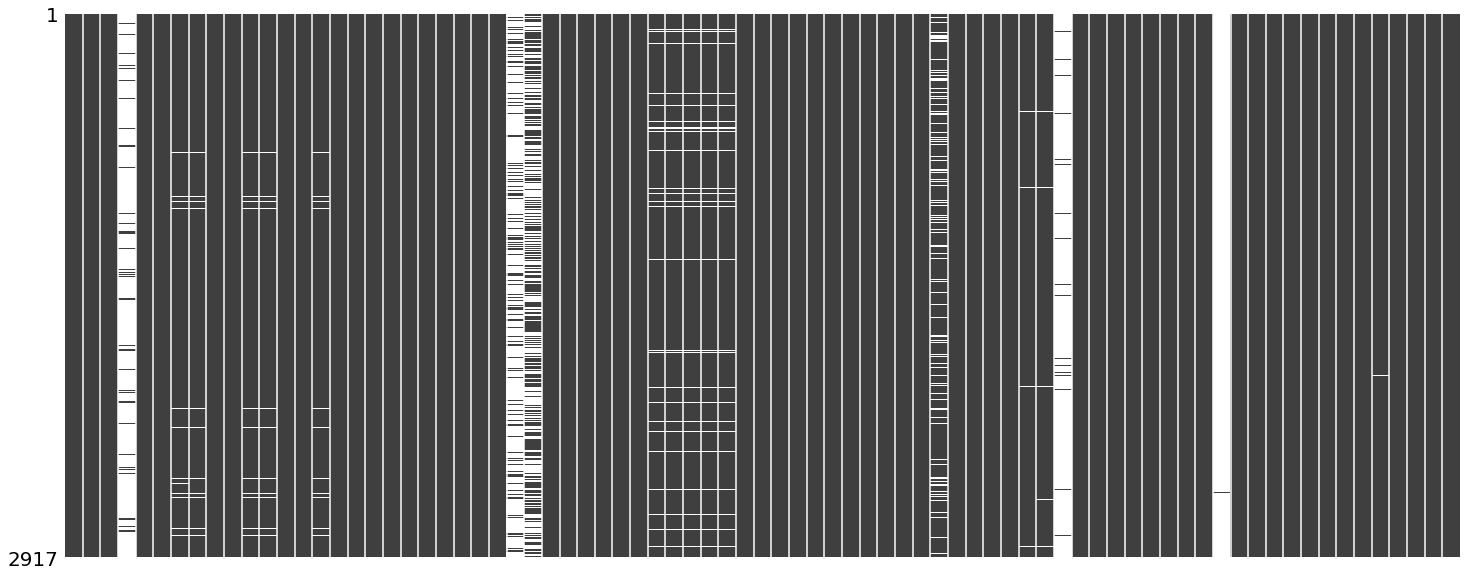

In [15]:
ms.matrix(all_data,sparkline=False)

In [16]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


In [17]:
all_data[all_data['PoolQC'].notnull()]['PoolQC']

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

Text(0.5, 1.0, 'Percent missing data by feature')

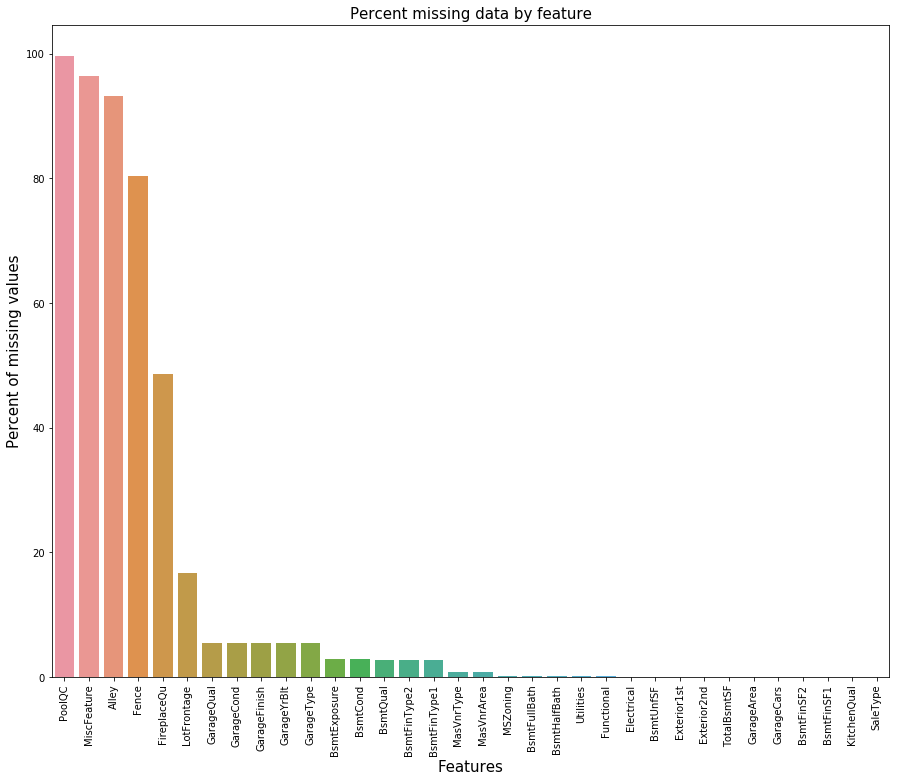

In [18]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Correlación de los Datos**


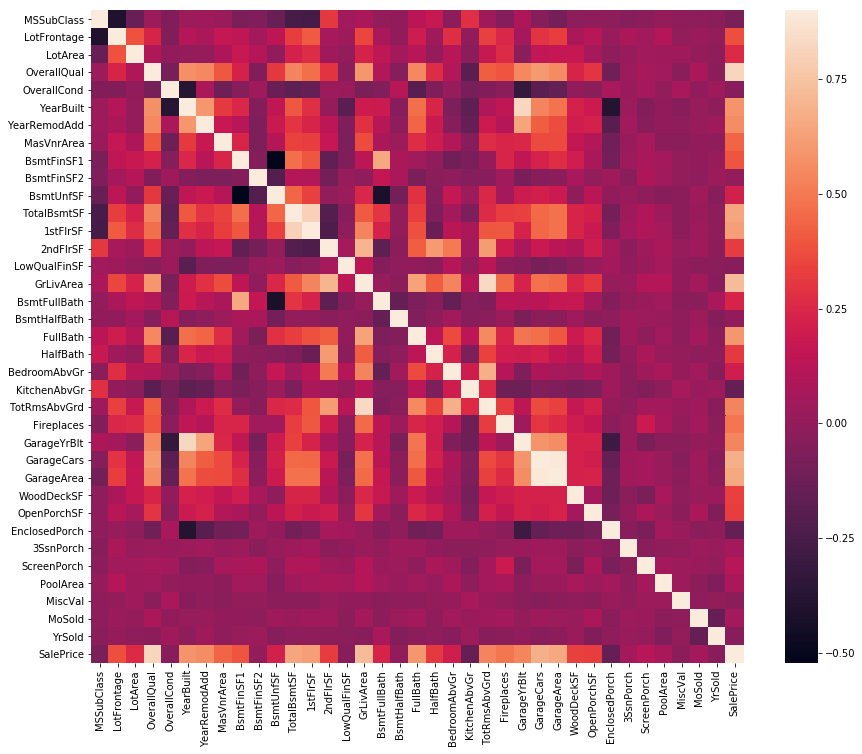

In [19]:
#Mapa de correlación para ver cómo las variables predictoras están correlacionadas con Precio
corrmat = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

###Completando valores nulos

Vamos a completar secuencialmente los nulos para todas las características que cuenten con valores perdidos.

We impute them  by proceeding sequentially  through features with missing values 

- **Piscina** : None hace referencia a que la casa no cuente con piscina.

In [0]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **Miscelaneo** : None hace referencia a que la casa no cuenta con características especiales que califiquen como Misceláneo


In [0]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Callejon** : None hace referencia a que la casa no cuenta con acceso a callejón.

In [0]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Cerca** : None hace referencia a que la casa no cuenta con cerca

In [0]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **ChimeneaCalidad** : None hace referencia a que la casa no cuenta con chimenea

In [0]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **Fachada** : Los valores perdidos de la **Fachada** los completaremos con la mediana obtenida al agrupar las casas por vecindario

In [0]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarajeTipo,GarajeExteriores,GarajeCalidad,GarajeCondición** : Los valores perdidos serán reemplazados por None para registrar que no cuentan con Garaje ni ninguna de sus características

In [0]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarajeAñosConstruido, GarajeArea y GarajeCarros** : Los valores perdidos los reemplazamos por cero (0) debido a que la casa no registró garaje.


In [0]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **SotanoAreaFinalizadaTipo1, SotanoAreaFinalizadaTipo2,SotanoAreaNoFinalizada, TotalAreaSotano, SotanoBañosCompletos y SotanosBañosSemicimpletos** :  Los valores perdidos los reemplazamos por cero (0) debido a que la casa no registró sótanos

In [0]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **SotanoCalidad, SotanoCondicion, SotanoExteriores, SotanoFinalizadoTipo1 and SotanoFinalizadoTipo2** : Los valores perdidos serán reemplazados por None para registrar que no cuentan con Sótano ni ninguna de sus características


In [0]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **ChapaAlbañileríaArea y ChapaAlbañileríaTipo** : Los valores perdidos serán reemplazados por cero (0) y None respectivamente para registrar que la casa no cuenta con Chapa de Albañilería


In [0]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **ClaseZona** :  Los valores perdidos serán reemplazados por la moda, es decir la característica más frecuente de la ClaseZona ('RL')

In [0]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : Esta variable está completamente llena con un **único valor para todos los registros** por ello no vamos a considerarla para la predicción.


In [0]:
all_data = all_data.drop(['Utilities'], axis=1)

- **TipoDeclaracionImpuestos** : Asumimos para los datos perdidos la cateogría **Typ** (típica) para la forma de declaración de impuestos

In [0]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **SistemaElectrico** : Solo presenta 1 dato perdido así que vamos a reemplazarlo por la moda


In [0]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **CocinaCalidad**:  Solo presenta 1 dato perdido así que vamos a reemplazarlo por la moda


In [0]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exteriores1erPiso and Exteriores2doPiso** : Ambas variables solo cuentan con 1 dato perdido así que vamos a reemplazarlo por la moda

In [0]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **TipoVenta** : Los valores perdidos serán reemplazados por la moda, es decir la característica más frecuente del tipo de venta

In [0]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **SubClase** : None hace referencia a que la casa no registró el tipo de construcción


In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Procedemos a verificar si queda algún dato nulo en el dataset:

In [39]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


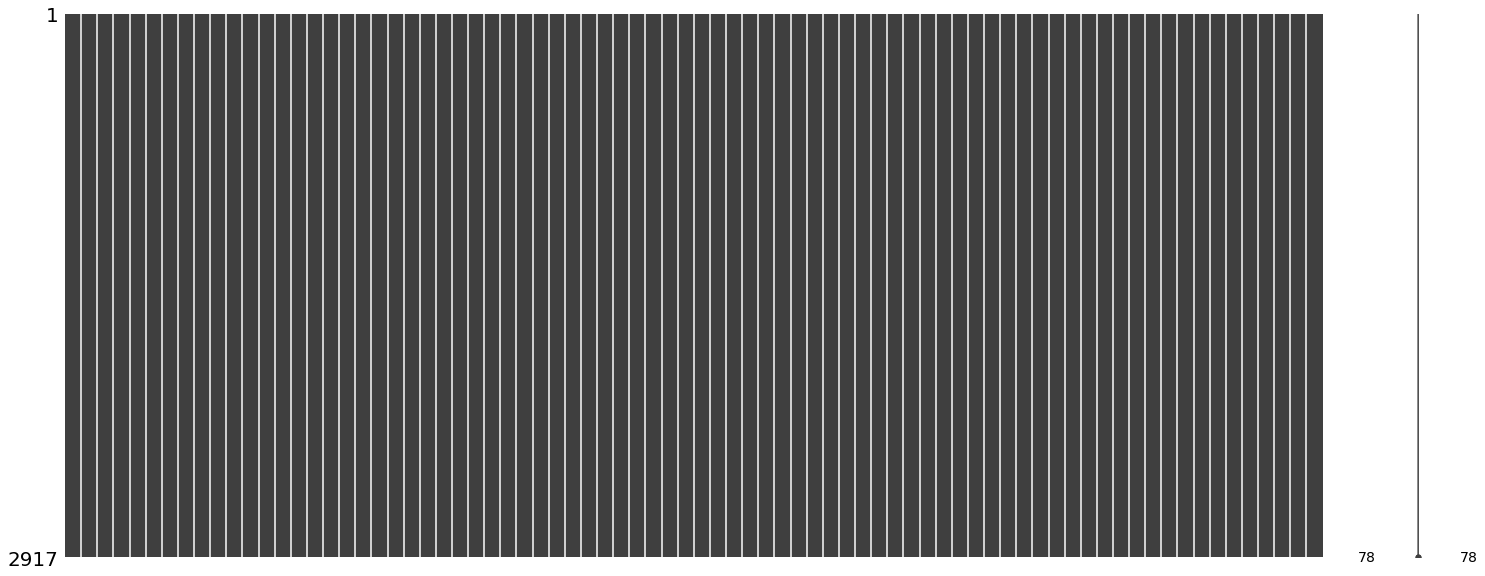

In [40]:
ms.matrix(all_data)

# Ingeniería de Características ( II )

**Transformando algunas variables númericas que realmente son categóricas**

In [41]:
print(all_data['YrSold'].unique(),all_data['MoSold'].unique())

[2008 2007 2006 2009 2010] [ 2  5  9 12 10  8 11  4  1  7  3  6]


In [0]:
#Cambiar la variable Tipo de construcción a tipo letra (str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)


#Cambiar la variable Condición general de la casa a tipo letra (str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Cambiar las variables Año y Mes de venta de la casa a tipo letra (str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [43]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    print(all_data[c].unique())

['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Gd' 'TA' 'Ex' 'None' 'Fa']
['TA' 'Gd' 'None' 'Fa' 'Po']
['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
['Gd' 'TA' 'Ex' 'Fa']
['TA' 'Gd' 'Fa' 'Po' 'Ex']
['Ex' 'Gd' 'TA' 'Fa' 'Po']
['None' 'Ex' 'Fa' 'Gd']
['Gd' 'TA' 'Ex' 'Fa']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
['No' 'Gd' 'Mn' 'Av' 'None']
['RFn' 'Unf' 'Fin' 'None']
['Gtl' 'Mod' 'Sev']
['Reg' 'IR1' 'IR2' 'IR3']
['Y' 'N' 'P']
['Pave' 'Grvl']
['None' 'Grvl' 'Pave']
['Y' 'N']
['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40' '150']
['5' '8' '6' '7' '4' '2' '3' '9' '1']
['2008' '2007' '2006' '2009' '2010']
['2' '5' '9' '12' '10' '8' '11' '4' '1' '7' '3' '6']


In [45]:
all_data['YearBuilt'].unique()

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1920, 1966, 1959, 1994, 1954, 1953, 1955,
       1983, 1975, 1997, 1934, 1963, 1981, 1964, 1999, 1972, 1921, 1945,
       1982, 1998, 1956, 1948, 1910, 1995, 1991, 2009, 1950, 1961, 1977,
       1985, 1979, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905, 1907, 1896, 1902, 1895, 1879, 1901])

**Añadimos una variable importante**

Debido a que el área total es importante para predecir el precio de la casa, sumamos las tres variables **TotalBase, 1erPiso, 2doPiso**

In [0]:
#Añadiendo tamaño total del area
all_data['TotalArea'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Detectamos el sesgo de las variables predictoras** - Solo aquellas con data numérica

In [47]:
#Filtramos aquellas variables que tengan datos diferentes al tipo object, es decir numéricas
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Aplicamos la función skew a las variables filtradas y mostramos el resultado ordenando de forma ascendente
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSesgo en características numéricas: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Sesgo en características numéricas: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


**Transformación Box Cox**

Usamos la transformación BoxCox de la librería scipy

In [48]:
skewness = skewness[abs(skewness) > 0.75]
print("Hay {} características numéricas que se han transformado vía BoxCox".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

Hay 33 características numéricas que se han transformado vía BoxCox


**Generamos nuevas variables dummy**

In [49]:
#all_data = pd.get_dummies(all_data)
X_re=pd.get_dummies(all_data, prefix_sep='_', drop_first=True)
print(all_data.shape)

(2917, 79)


In [50]:
X_re.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalArea,Alley_None,Alley_Pave,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Gd,...,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_None,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,11.692623,11.686189,0.0,1.540963,11.170327,0.0,0.730463,0.000000,7.483296,0.000000,0.000000,1.194318,10.506271,1.194318,14.187527,13.698888,0.730463,0.730463,19.212182,5.831328,0.0,8.059126,0.0,5.714669,2.440268,0.0,0.0,2.602594,11.692623,0.000000,14.187527,14.187527,14.976591,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
1,12.792276,0.000000,0.0,1.540963,12.062832,0.0,0.000000,0.730463,8.897844,0.000000,0.730463,1.194318,10.062098,1.194318,14.145138,12.792276,0.000000,0.730463,19.712205,6.221214,0.0,0.000000,0.0,0.000000,2.259674,0.0,0.0,2.259674,12.792276,9.010206,14.145138,14.145138,14.923100,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0
2,11.892039,11.724598,0.0,1.540963,10.200343,0.0,0.730463,0.000000,9.917060,0.000000,0.730463,1.194318,10.775536,1.194318,14.184404,13.832085,0.730463,0.730463,20.347241,5.914940,0.0,7.646538,0.0,5.053371,2.440268,0.0,0.0,2.259674,11.892039,0.000000,14.184404,14.185966,15.149678,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,12.013683,11.354094,0.0,1.540963,8.274266,0.0,0.730463,0.000000,10.468500,8.797736,0.730463,0.730463,10.918253,1.540963,14.179714,13.711364,0.000000,0.730463,19.691553,5.684507,0.0,0.000000,0.0,4.745132,2.440268,0.0,0.0,2.440268,11.354094,0.000000,14.047529,14.135652,14.857121,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,12.510588,12.271365,0.0,1.820334,10.971129,0.0,0.730463,0.000000,10.221051,0.000000,0.730463,1.194318,11.627708,1.540963,14.182841,14.480029,0.730463,0.730463,21.325160,6.314735,0.0,9.391827,0.0,6.314735,2.602594,0.0,0.0,2.750250,12.510588,8.013884,14.182841,14.182841,15.852312,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0


In [51]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalArea
0,11.692623,11.686189,0.0,None,1.540963,1Fam,TA,No,11.170327,0.0,GLQ,Unf,0.730463,0.000000,Gd,7.483296,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,VinylSd,None,None,0.000000,PConc,1.194318,Typ,10.506271,1.194318,TA,RFn,TA,Attchd,14.187527,13.698888,0.730463,GasA,Ex,2Story,0.730463,Gd,Lvl,Gtl,19.212182,Inside,5.831328,Reg,0.0,60,RL,8.059126,BrkFace,None,0.0,2,CollgCr,5.714669,5,2.440268,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.602594,11.692623,0.000000,14.187527,14.187527,2008,14.976591
1,12.792276,0.000000,0.0,None,1.540963,1Fam,TA,Gd,12.062832,0.0,ALQ,Unf,0.000000,0.730463,Gd,8.897844,Y,Feedr,Norm,SBrkr,0.000000,TA,TA,MetalSd,MetalSd,None,TA,0.730463,CBlock,1.194318,Typ,10.062098,1.194318,TA,RFn,TA,Attchd,14.145138,12.792276,0.000000,GasA,Ex,1Story,0.730463,TA,Lvl,Gtl,19.712205,FR2,6.221214,Reg,0.0,20,RL,0.000000,None,None,0.0,5,Veenker,0.000000,8,2.259674,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.259674,12.792276,9.010206,14.145138,14.145138,2007,14.923100
2,11.892039,11.724598,0.0,None,1.540963,1Fam,TA,Mn,10.200343,0.0,GLQ,Unf,0.730463,0.000000,Gd,9.917060,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,VinylSd,None,TA,0.730463,PConc,1.194318,Typ,10.775536,1.194318,TA,RFn,TA,Attchd,14.184404,13.832085,0.730463,GasA,Ex,2Story,0.730463,Gd,Lvl,Gtl,20.347241,Inside,5.914940,IR1,0.0,60,RL,7.646538,BrkFace,None,0.0,9,CollgCr,5.053371,5,2.440268,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.259674,11.892039,0.000000,14.184404,14.185966,2008,15.149678
3,12.013683,11.354094,0.0,None,1.540963,1Fam,Gd,No,8.274266,0.0,ALQ,Unf,0.730463,0.000000,TA,10.468500,Y,Norm,Norm,SBrkr,8.797736,TA,TA,Wd Sdng,Wd Shng,None,Gd,0.730463,BrkTil,0.730463,Typ,10.918253,1.540963,TA,Unf,TA,Detchd,14.179714,13.711364,0.000000,GasA,Gd,2Story,0.730463,Gd,Lvl,Gtl,19.691553,Corner,5.684507,IR1,0.0,70,RL,0.000000,None,None,0.0,2,Crawfor,4.745132,5,2.440268,Y,0.0,None,CompShg,Gable,Abnorml,WD,0.0,Pave,2.440268,11.354094,0.000000,14.047529,14.135652,2006,14.857121
4,12.510588,12.271365,0.0,None,1.820334,1Fam,TA,Av,10.971129,0.0,GLQ,Unf,0.730463,0.000000,Gd,10.221051,Y,Norm,Norm,SBrkr,0.000000,TA,Gd,VinylSd,VinylSd,None,TA,0.730463,PConc,1.194318,Typ,11.627708,1.540963,TA,RFn,TA,Attchd,14.182841,14.480029,0.730463,GasA,Ex,2Story,0.730463,Gd,Lvl,Gtl,21.325160,FR2,6.314735,IR1,0.0,60,RL,9.391827,BrkFace,None,0.0,12,NoRidge,6.314735,5,2.602594,Y,0.0,None,CompShg,Gable,Normal,WD,0.0,Pave,2.750250,12.510588,8.013884,14.182841,14.182841,2008,15.852312


In [0]:
all_data=X_re

Redifinimos el dataset train y test

In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]


# Modelos

**Importamos librerías**

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error



**Definir una estrategia de validación cruzada para optimizar los parámetros ingresados**

Usamos la función **cross_val_score** de la librería scikit-learn.
Para aleatorizar la validación previamente creamos una variable **kf**

In [0]:
#Predefinimos la variables n_folds con valor 5
n_folds = 5

#Creamos la función rmsle_cv para aplicar cross_val_score
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

##Modelos Base

-  **Regresión Lasso**  : 

Este modelo es muy sensible a outliers, por ello necesitamos hacer más robusto el modelo a través del parámetro **Robustscaler** dentro de un pipeline

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Regresión ElasticNet** :

Nuevamente ingresamos el parámetro **Robustscaler** dentro del pipeline para hacer más robusto el modelo

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Regresión Kernel Ridge** :

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Evaluación de los Modelos Base

In [59]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1147 (0.0060)



In [60]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1146 (0.0061)



In [61]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1160 (0.0053)



# Stacking  models

Agregacion de modelos , se usan los resultados de los modelos anteriores y se promedian para obtener un predictor mas avanzado

In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [64]:
averaged_models = AveragingModels(models = (ENet, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1134 (0.0059)

